https://www.kaggle.com/datasets/arnaud58/landscape-pictures

Import packages

In [1]:
# from PIL import Image
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

Load and treat images

In [2]:


image_dir = "/content/drive/MyDrive/NM6sem/images"
image_files = os.listdir(image_dir)

target_size = (228, 128)

images = []

for file_name in image_files:
    file_path = os.path.join(image_dir, file_name)
    image = cv2.imread(file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    images.append((image / 127.5) - 1.0)
    print(len(images),file_name)

images = np.array(images)


1 00000585_(3).jpg
2 00000573_(4).jpg
3 00000577_(3).jpg
4 00000578_(3).jpg
5 00000573.jpg
6 00000584_(3).jpg
7 00000585.jpg
8 00000579_(3).jpg
9 00000586_(4).jpg
10 00000579_(4).jpg
11 00000582_(4).jpg
12 00000573_(2).jpg
13 00000574_(4).jpg
14 00000573_(3).jpg
15 00000585_(2).jpg
16 00000580_(2).jpg
17 00000580_(4).jpg
18 00000576_(4).jpg
19 00000588_(3).jpg
20 00000582_(3).jpg
21 00000575_(3).jpg
22 00000582_(2).jpg
23 00000579.jpg
24 00000578_(4).jpg
25 00000575_(2).jpg
26 00000581.jpg
27 00000578_(2).jpg
28 00000582.jpg
29 00000588.jpg
30 00000586_(3).jpg
31 00000575.jpg
32 00000580_(3).jpg
33 00000585_(4).jpg
34 00000587_(2).jpg
35 00000587_(4).jpg
36 00000576_(3).jpg
37 00000581_(2).jpg
38 00000574_(2).jpg
39 00000586_(2).jpg
40 00000586.jpg
41 00000579_(2).jpg
42 00000584.jpg
43 00000576.jpg
44 00000587.jpg
45 00000581_(3).jpg
46 00000580.jpg
47 00000575_(4).jpg
48 00000583_(2).jpg
49 00000583.jpg
50 00000583_(4).jpg
51 00000577_(4).jpg
52 00000577.jpg
53 00000574_(3).jpg
54 00

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 116736)            11673600  
                                                                 
 batch_normalization (Batch  (None, 116736)            466944    
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 116736)            0         
                                                                 
 reshape (Reshape)           (None, 32, 57, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 32, 57, 64)        102400    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 32, 57, 64)        2

1
2
3
4
5
6
7
8
9


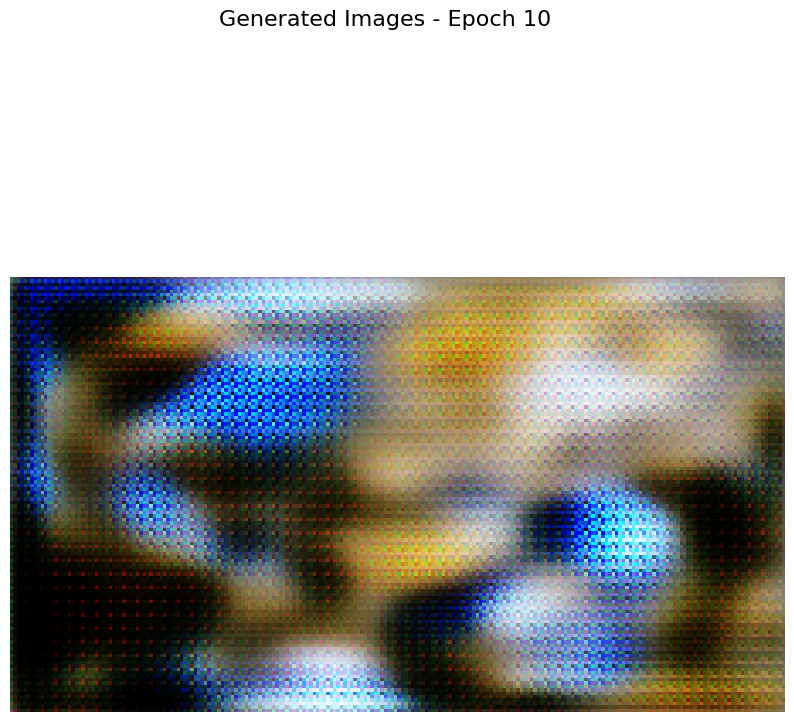

10
11
12
13
14
15
16
17
18
19


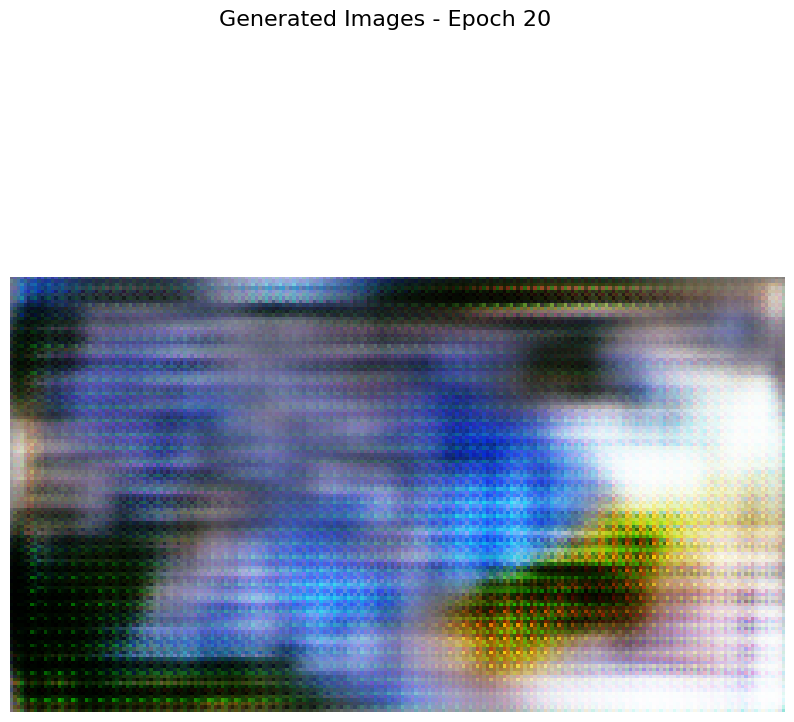

20
21
22
23
24
25
26
27
28
29


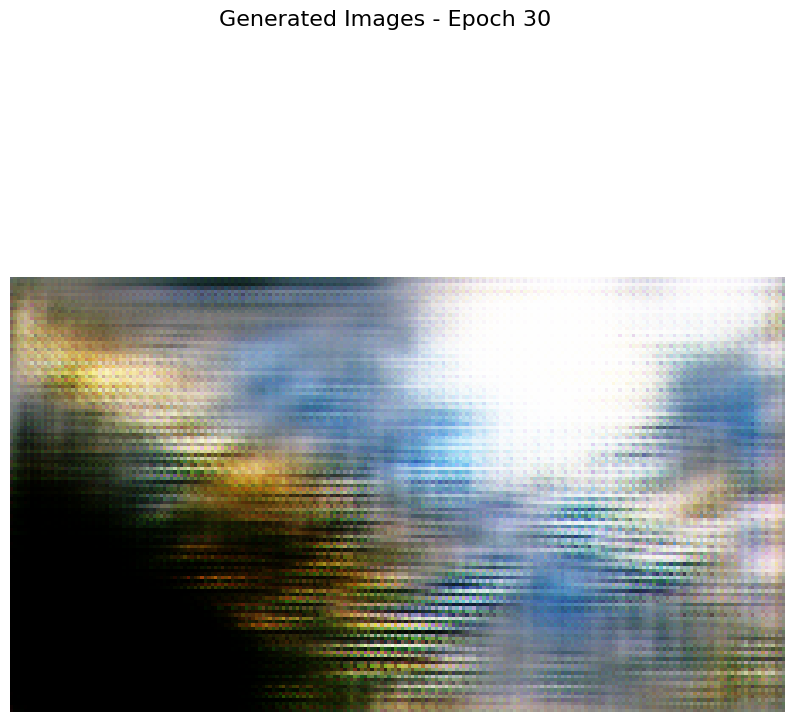

30
31
32
33
34
35
36
37
38
39


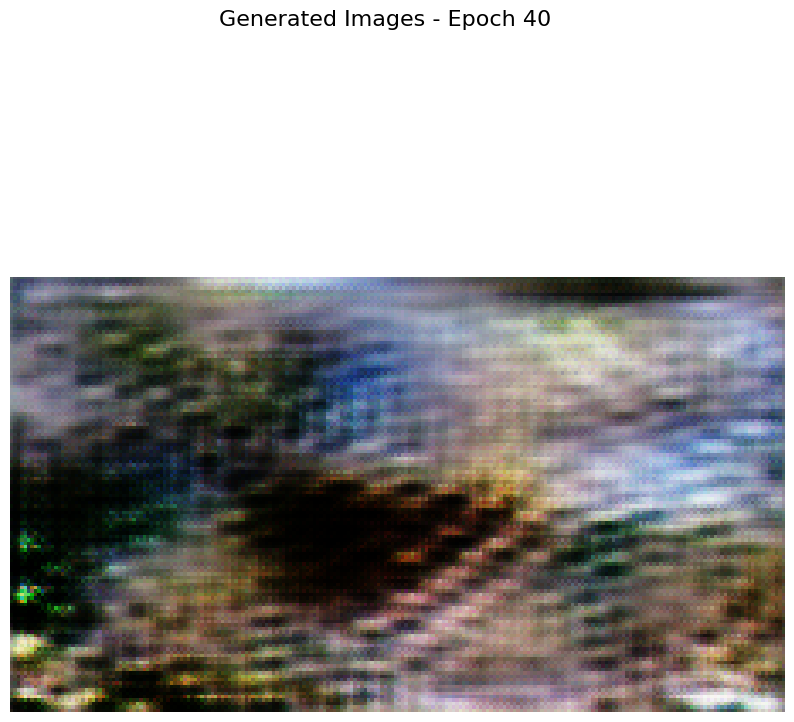

40
41
42
43
44
45
46
47
48
49


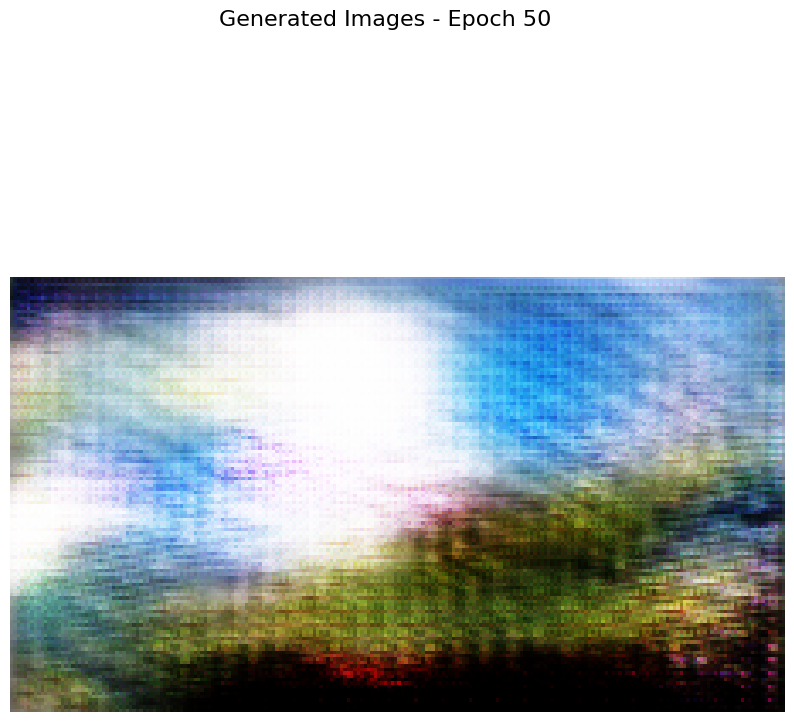

In [4]:
def build_generator():
    model = models.Sequential()
    model.add(layers.Dense(32*57*64, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((32, 57, 64)))
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

generator = build_generator()
generator.summary()

def build_discriminator():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=[128, 228, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = build_discriminator()
discriminator.summary()

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


def visualize_generated_images(generator, epoch, noise_dim=100, num_examples=1):
    
    noise = tf.random.normal([num_examples, noise_dim])
    generated_images = generator(noise, training=False)

    plt.figure(figsize=(10, 10))
    for i in range(num_examples):
        plt.subplot(1, num_examples, i + 1)
        plt.imshow((generated_images[i] + 1) / 2)
        plt.axis('off')
    plt.suptitle(f'Generated Images - Epoch {epoch+1}', fontsize=16)
    plt.show()

BATCH_SIZE = 32
noise_dim = 100
epochs = 50

for epoch in range(epochs):
  print(epoch)
  for i in range(images.shape[0] // BATCH_SIZE):
      batch_images = images[i * BATCH_SIZE: (i + 1) * BATCH_SIZE]
      train_step(batch_images)

  if (epoch + 1) % 10 == 0:
      visualize_generated_images(generator, epoch, noise_dim=noise_dim)

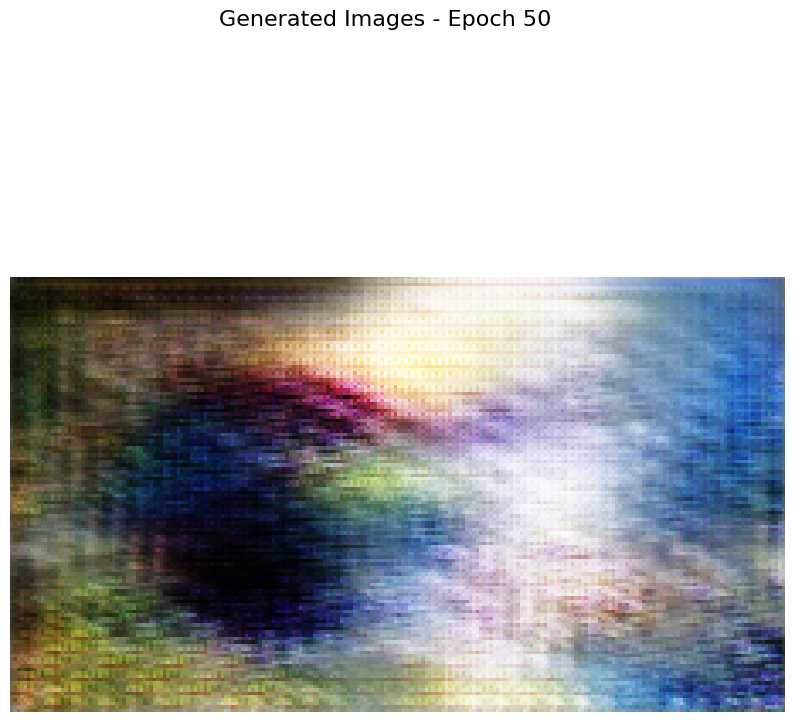

In [6]:
visualize_generated_images(generator, epoch, noise_dim=noise_dim)

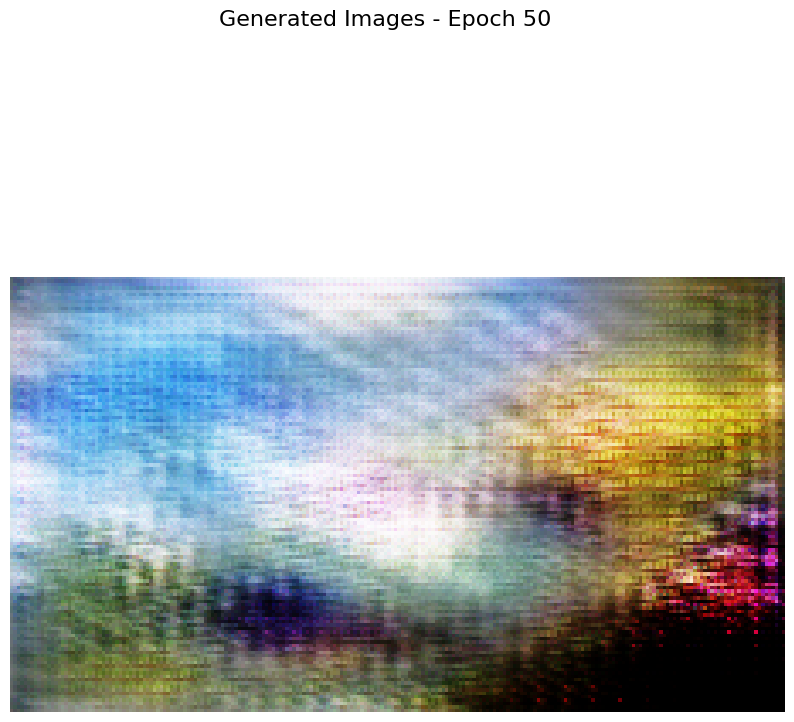

In [7]:
visualize_generated_images(generator, epoch, noise_dim=noise_dim)

In [8]:
def visualize_generated_images_2(generator, epoch, noise_dim=100, num_examples=1, image_size=(32, 32)):
    
    noise = tf.random.normal([num_examples, noise_dim])
    
    generated_images = generator(noise, training=False)

    
    plt.figure(figsize=(8, 4))  
    for i in range(num_examples):
        plt.subplot(1, num_examples, i + 1)
        
        resized_image = tf.image.resize((generated_images[i] + 1) / 2, image_size)
        plt.imshow(resized_image)
        plt.axis('off')
    plt.suptitle(f'Generated Images - Epoch {epoch+1}', fontsize=16)
    plt.show()


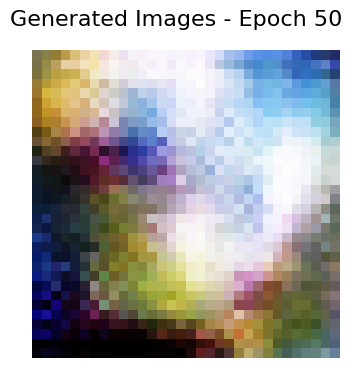

In [11]:
visualize_generated_images_2(generator, epoch, noise_dim=noise_dim)

In [12]:
def visualize_generated_images_3(generator, epoch, noise_dim=100, num_examples=1, figsize=(6, 3)):
    
    noise = tf.random.normal([num_examples, noise_dim])
    
    generated_images = generator(noise, training=False)

    
    plt.figure(figsize=figsize)  
    for i in range(num_examples):
        plt.subplot(1, num_examples, i + 1)
        
        plt.imshow((generated_images[i] + 1) / 2, interpolation='nearest')
        plt.axis('off')
    plt.suptitle(f'Generated Images - Epoch {epoch+1}', fontsize=16)
    plt.show()


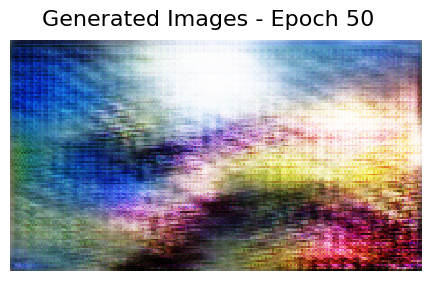

In [14]:
visualize_generated_images_3(generator, epoch, noise_dim=noise_dim)

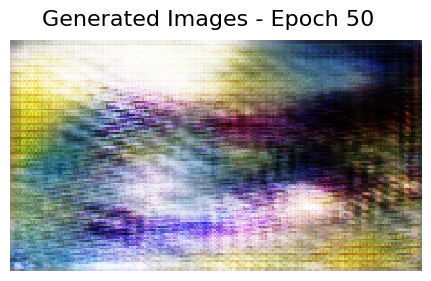

In [15]:
visualize_generated_images_3(generator, epoch, noise_dim=noise_dim)

0
1
2
3
4
5
6
7
8
9


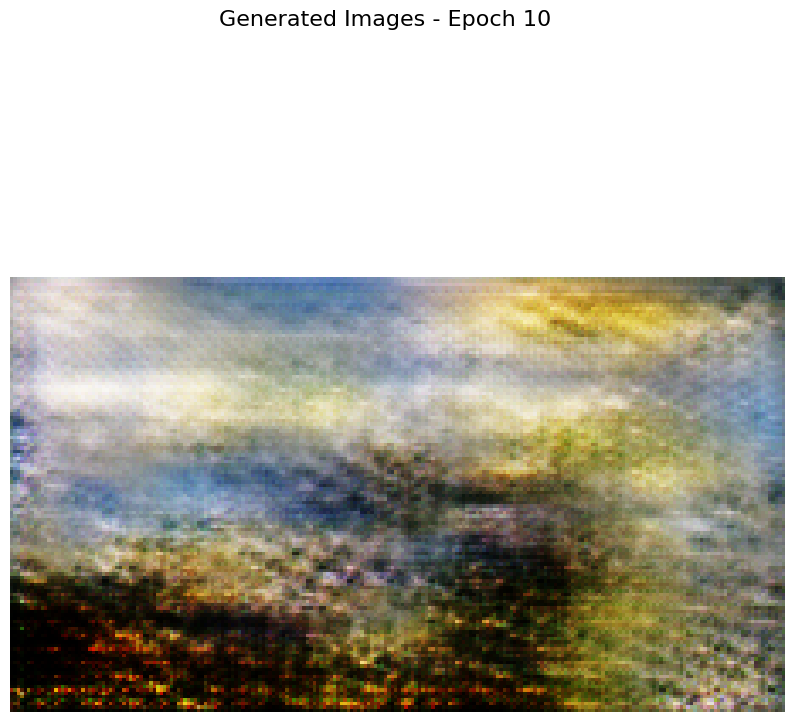

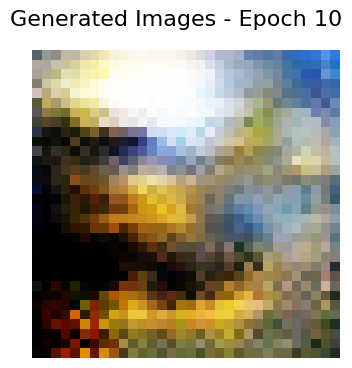

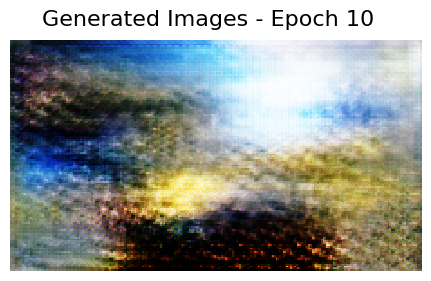

In [16]:
for epoch in range(10):
  print(epoch)
  for i in range(images.shape[0] // BATCH_SIZE):
      batch_images = images[i * BATCH_SIZE: (i + 1) * BATCH_SIZE]
      train_step(batch_images)

  
  if (epoch + 1) % 10 == 0:
      visualize_generated_images(generator, epoch, noise_dim=noise_dim)
      visualize_generated_images_2(generator, epoch, noise_dim=noise_dim)
      visualize_generated_images_3(generator, epoch, noise_dim=noise_dim)

In [26]:
from scipy.ndimage import gaussian_filter

def visualize_generated_images_4(generator, epoch, noise_dim=100, num_examples=1, figsize=(6, 3), blur_sigma=0.9):

    noise = tf.random.normal([num_examples, noise_dim])

    generated_images = generator(noise, training=False)


    plt.figure(figsize=figsize) 
    for i in range(num_examples):
        plt.subplot(1, num_examples, i + 1)
    
        blurred_image = gaussian_filter((generated_images[i] + 1) / 2, sigma=blur_sigma)
        plt.imshow(blurred_image, interpolation='nearest')
        plt.axis('off')
    plt.suptitle(f'Generated Images - Epoch {epoch+1}', fontsize=16)
    plt.show()


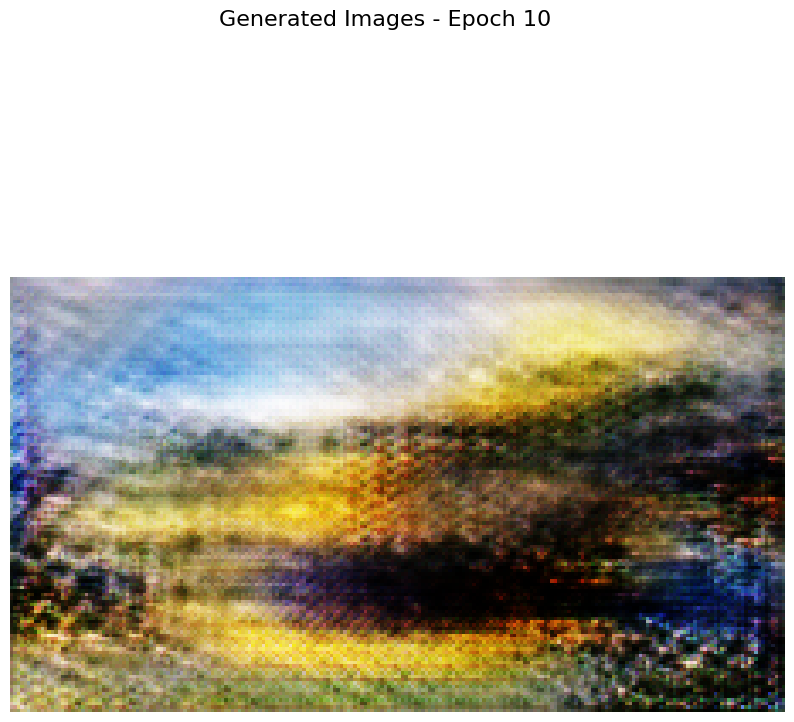

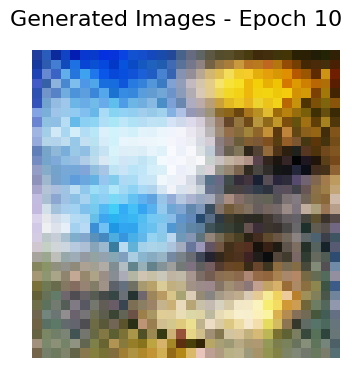

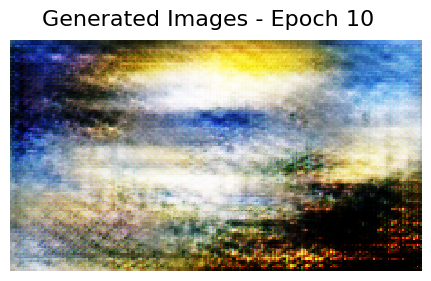

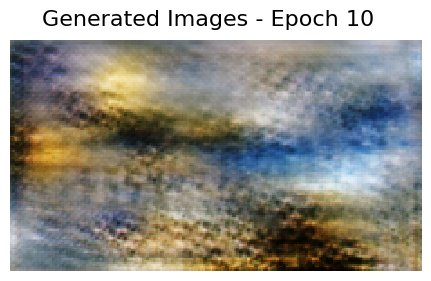

In [18]:
visualize_generated_images(generator, epoch, noise_dim=noise_dim)
visualize_generated_images_2(generator, epoch, noise_dim=noise_dim)
visualize_generated_images_3(generator, epoch, noise_dim=noise_dim)
visualize_generated_images_4(generator, epoch, noise_dim=noise_dim)

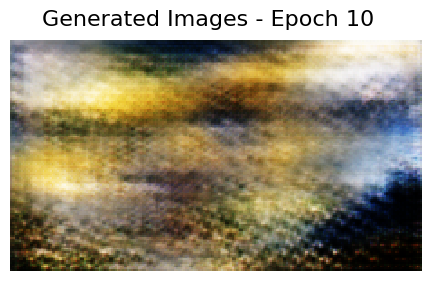

In [19]:
visualize_generated_images_4(generator, epoch, noise_dim=noise_dim)

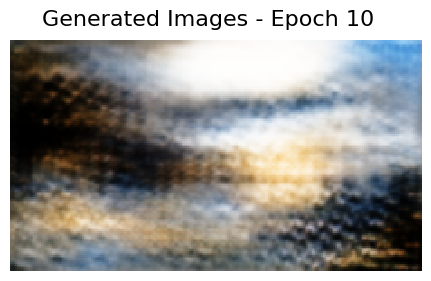

In [21]:
visualize_generated_images_4(generator, epoch, noise_dim=noise_dim)

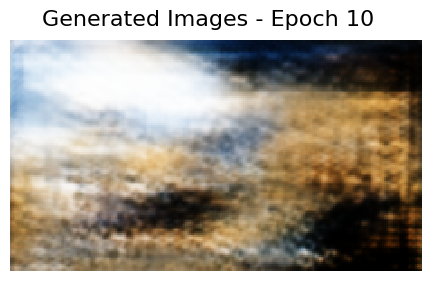

In [22]:
visualize_generated_images_4(generator, epoch, noise_dim=noise_dim)

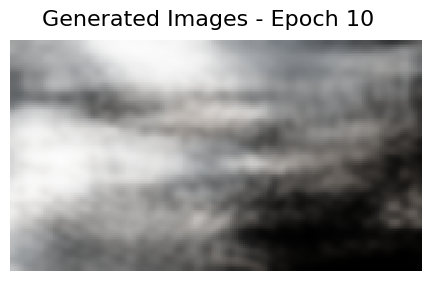

In [24]:
visualize_generated_images_4(generator, epoch, noise_dim=noise_dim)

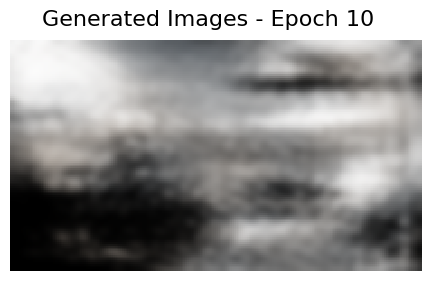

In [25]:
visualize_generated_images_4(generator, epoch, noise_dim=noise_dim)

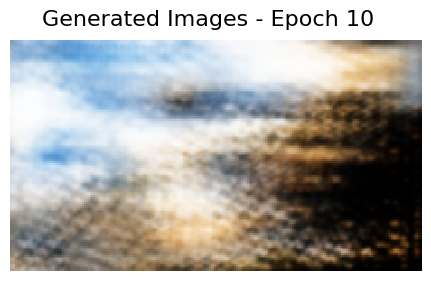

In [27]:
visualize_generated_images_4(generator, epoch, noise_dim=noise_dim)

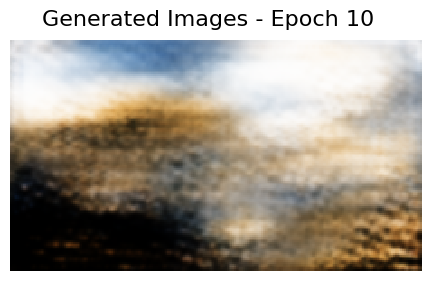

In [28]:
visualize_generated_images_4(generator, epoch, noise_dim=noise_dim)

In [32]:
def visualize_generated_images_5(generator, epoch, noise_dim=100, num_examples=1,blur_sigma=0.8,filter_mode='reflect'):
    
    noise = tf.random.normal([num_examples, noise_dim])
    
    generated_images = generator(noise, training=False)

    
    plt.figure(figsize=(10, 10))
    for i in range(num_examples):
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(gaussian_filter((generated_images[i] + 1) / 2,sigma=blur_sigma,mode=filter_mode))  
        plt.axis('off')
    plt.suptitle(f'Generated Images - Epoch {epoch+1}', fontsize=16)
    plt.show()

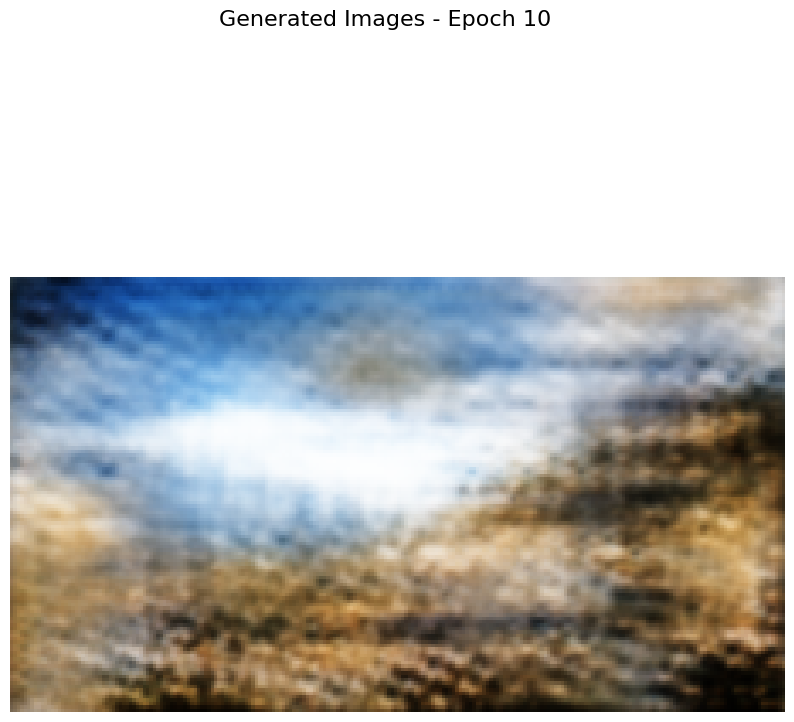

In [33]:
visualize_generated_images_5(generator, epoch, noise_dim=noise_dim,filter_mode='reflect')

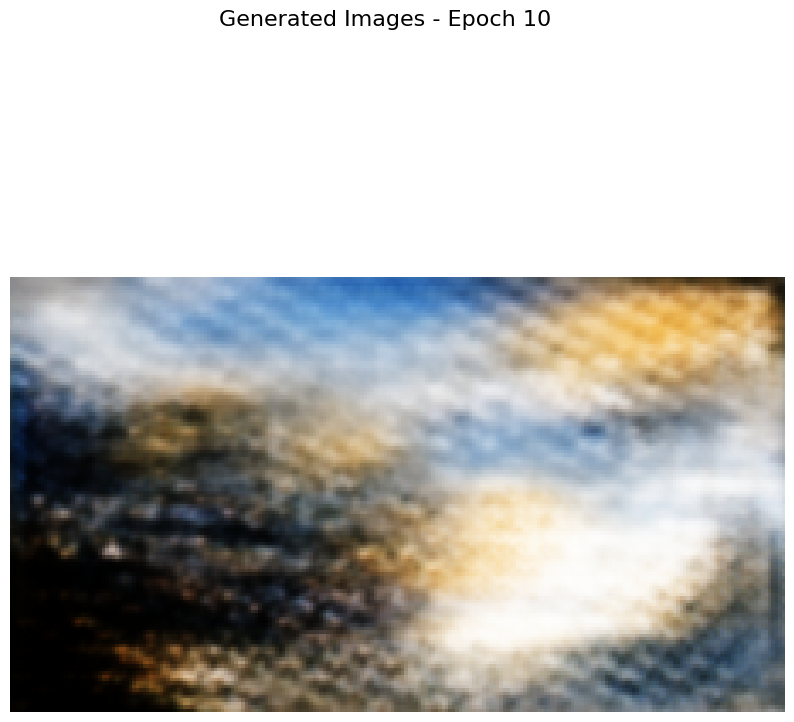

In [34]:
visualize_generated_images_5(generator, epoch, noise_dim=noise_dim,filter_mode='nearest')

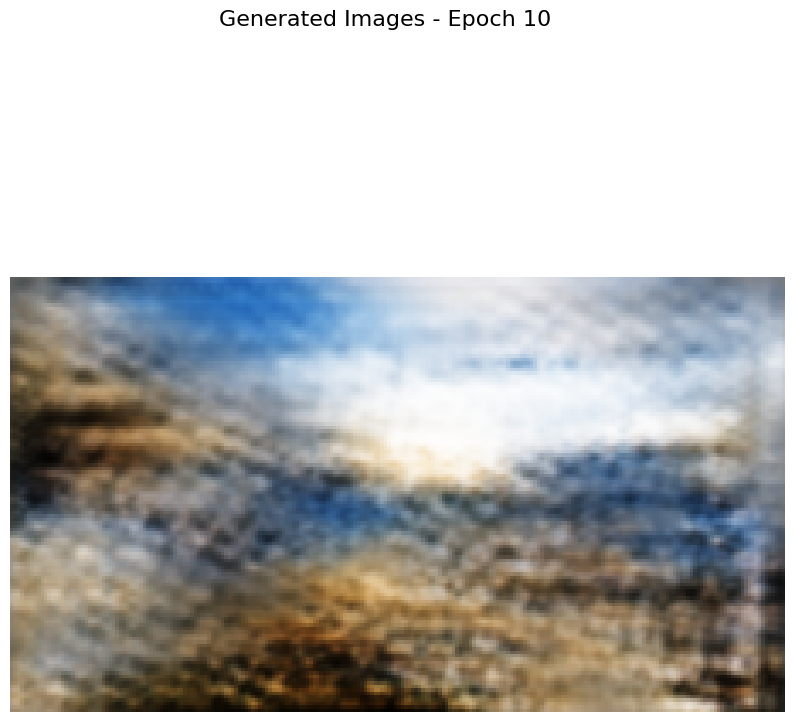

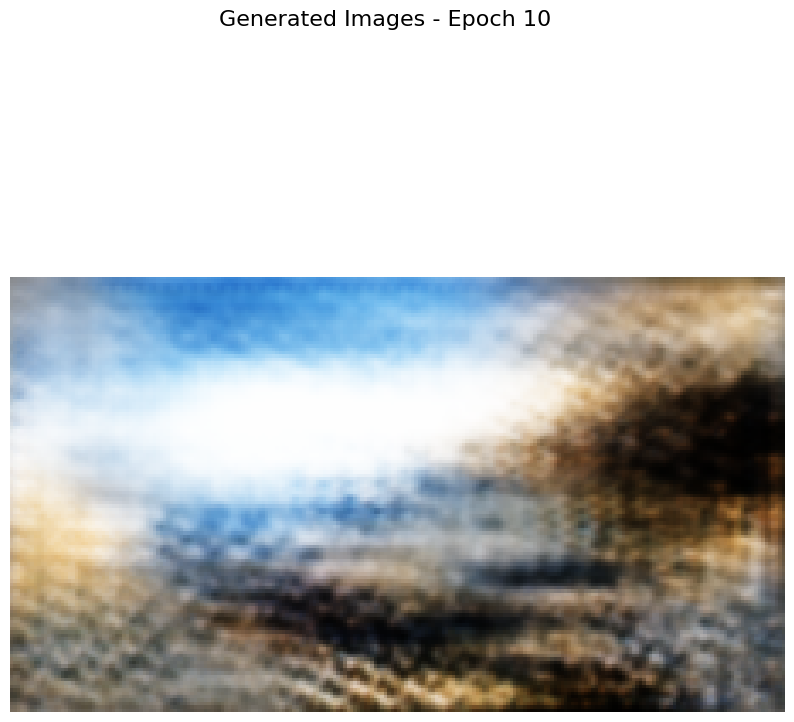

In [35]:
visualize_generated_images_5(generator, epoch, noise_dim=noise_dim,filter_mode='reflect')
visualize_generated_images_5(generator, epoch, noise_dim=noise_dim,filter_mode='nearest')